## Preparación del entorno
En un primer momento debemos descargar los datos, lo cual se realiza unsando la capacidad de jupyter de ejecutar comandos de shell, e importamos las librerías que se requieren para el proyecto.

In [4]:
!mkdir -p data/raw
!curl -L -o walmart-sales-forecast.zip https://www.kaggle.com/api/v1/datasets/download/aslanahmedov/walmart-sales-forecast
!unzip -o walmart-sales-forecast.zip -d data/raw
!rm walmart-sales-forecast.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3441k  100 3441k    0     0  6043k      0 --:--:-- --:--:-- --:--:-- 6043k
Archive:  walmart-sales-forecast.zip
  inflating: data/raw/features.csv   
  inflating: data/raw/stores.csv     
  inflating: data/raw/test.csv       
  inflating: data/raw/train.csv      


In [5]:
# Manipulación de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Manejo de fechas
from datetime import datetime, timedelta
import math

# Tratamiento estadístico
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose


# Preprocesamiento y selección de características
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Sistema y Modelos
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [6]:
import os
# Ahora se configura el estilo de los gráficos y la visualización de los datos
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 20
pd.options.display.float_format = '{:.2f}'.format

In [7]:
# Se cargan los datasets correspondientes
df_train = pd.read_csv('data/raw/train.csv')
df_stores = pd.read_csv('data/raw/stores.csv')
df_features = pd.read_csv('data/raw/features.csv')

## Preparación de los datos
Debido a que los datos están distribuidos por tres datasets, se deben unir para poder trabajar con un unico dataframe de variables independientes. Para ello se realiza un merge de los tres dataset.

In [8]:
# Examinamos primeros y los últimos registros de los datasets
print('Train dataset')
df_train

Train dataset


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [9]:
print('Stores dataset')
df_stores

Stores dataset


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
...,...,...,...
40,41,A,196321
41,42,C,39690
42,43,C,41062
43,44,C,39910


In [10]:
print('Features dataset')
df_features

Features dataset


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,False
1,1,2010-02-12,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11,True
2,1,2010-02-19,39.93,2.51,NaN,NaN,NaN,NaN,NaN,211.29,8.11,False
3,1,2010-02-26,46.63,2.56,NaN,NaN,NaN,NaN,NaN,211.32,8.11,False
4,1,2010-03-05,46.50,2.62,NaN,NaN,NaN,NaN,NaN,211.35,8.11,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.64,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.61,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.61,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.74,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


Podemos notar que cada dataset tiene una columna "store", la cual identifica a la tienda a la que pertenece la fila. y que tanto el dataset train y features tienen una columna "Date", que identifica la fecha a la que corresponden los datos para una tienda en particular.

Y que el dataset de stores tiene una columna "store" que registra información sobre la tienda.

Es por esto que se realiza un merge de los dos dataset con la columna "store" y "Date" como llave, y luego se realiza un merge de este resultado con el dataset de stores, utilizando la columna "store" como llave.

Nota: Se hace merge también con la columan IsHoliday, ya que esta está presente en ambos datasets, y así se evita que se dupliquen las columnas.


In [11]:
df_train_features = df_train.merge(df_features, on=['Store', 'Date', 'IsHoliday'], how='inner')
df = df_train_features.merge(df_stores, on=['Store'], how='inner')

df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.57,NaN,NaN,NaN,NaN,NaN,211.10,8.11,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.55,NaN,NaN,NaN,NaN,NaN,211.24,8.11,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.51,NaN,NaN,NaN,NaN,NaN,211.29,8.11,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.56,NaN,NaN,NaN,NaN,NaN,211.32,8.11,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.62,NaN,NaN,NaN,NaN,NaN,211.35,8.11,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,4.00,4556.61,20.64,1.50,1601.01,3288.25,192.01,8.68,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.98,5046.74,NaN,18.82,2253.43,2340.01,192.17,8.67,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.00,1956.28,NaN,7.89,599.32,3990.54,192.33,8.67,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.97,2004.02,NaN,3.18,437.73,1537.49,192.33,8.67,B,118221


## Análisis exploratorio de datos
Se realiza un análisis exploratorio de los datos para comprender el dominio del problema.

In [12]:
# Exploración del numero de tiendas y departamentos
print('Número de tiendas: ', df['Store'].nunique())
print('Número de departamentos: ', df['Dept'].nunique())

Número de tiendas:  45
Número de departamentos:  81


In [13]:
# A continuación se explora el promedio de ventas por tienda y departamento
pd.pivot_table(df, index='Store', columns='Dept', values='Weekly_Sales', aggfunc='mean')

Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,...,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.32,46102.09,13150.48,36964.15,24257.94,4801.78,24566.49,35718.26,28062.05,31033.39,24919.27,10566.55,38692.88,15268.55,24151.06,9196.56,7765.30,1259.02,4091.57,7808.45,8052.08,21623.18,6187.39,10152.34,6768.00,...,1021.00,NaN,7436.02,2732.47,47390.64,11652.83,677.00,11.50,33974.79,17139.31,29780.70,20727.86,5704.05,3685.88,46006.28,82427.55,64238.94,135458.97,71699.18,63180.57,120772.06,33251.83,35207.35,11827.77,306.09
2,30777.98,65912.92,17476.56,45607.67,30555.32,6808.38,40477.84,58707.37,34375.86,38845.85,23382.69,7735.95,46117.96,21314.13,27005.18,13790.85,11687.56,4053.44,5748.62,9910.94,12923.01,29170.62,8309.56,15299.51,9347.73,...,221.55,NaN,12125.26,4634.61,72929.50,16986.41,817.50,11.76,32759.10,26041.27,31000.48,24647.23,5710.72,3672.04,24932.99,97611.54,80610.38,164840.23,70581.98,70018.67,143588.75,34319.06,40697.20,14035.40,475.90
3,7328.62,16841.78,5509.30,8434.19,11695.37,2012.41,10044.34,8310.25,9062.01,10871.94,8774.93,2383.60,11363.06,4626.65,7871.57,2634.20,2960.68,731.31,1682.20,1244.53,3101.77,10913.33,2763.63,4260.45,2850.05,...,138.13,NaN,2021.48,1101.61,22796.86,3374.96,424.00,6.00,7230.37,24.42,1429.30,6746.58,19.33,874.13,939.44,1540.05,318.69,7568.28,NaN,656.29,15745.53,3934.54,343.44,30.57,NaN
4,36979.94,93639.32,19012.49,56603.40,45668.41,8241.78,50728.15,62949.72,34437.17,37269.67,27145.84,8141.91,69596.45,28567.51,21270.15,15815.88,13146.54,3038.32,8888.30,8865.27,17289.92,46234.01,10875.30,15640.75,18429.76,...,410.80,NaN,12471.43,7686.02,101244.45,20627.31,344.57,5.38,52436.66,19379.10,31055.29,29371.32,9161.22,2730.06,14223.46,89248.97,66535.41,159365.11,67815.16,68159.11,147236.47,38346.57,39339.24,15009.25,623.18
5,9774.55,12317.95,4101.09,9860.81,6699.20,1191.06,6124.48,13735.71,7919.81,9783.40,7389.05,2515.35,11242.66,3697.42,7717.57,2396.78,2185.89,46.33,1220.83,1316.41,2430.05,6141.86,1480.23,2685.58,1782.21,...,236.53,NaN,3036.86,456.66,11656.52,3523.77,465.07,6.00,5009.17,6.08,2615.84,3887.79,NaN,935.08,10089.58,3059.52,1457.22,7759.21,NaN,411.43,19340.69,5985.67,667.07,29.98,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,23205.26,48349.83,17021.83,30538.57,25513.94,5267.83,33711.11,33729.08,32743.47,15194.22,13605.68,4273.26,32563.00,17161.99,18588.11,12054.24,9113.08,1163.51,5546.32,5066.60,10331.84,18920.31,5172.03,7374.31,6488.95,...,455.33,NaN,9756.68,5300.85,54877.30,18638.24,231.50,9.00,21840.98,17436.27,19958.05,18788.88,3879.17,2272.11,10042.53,70852.02,52714.93,115827.66,35415.34,47218.53,88666.47,2883.49,19789.22,9371.53,443.74
42,10375.15,15976.90,814.45,14885.26,1052.30,3.33,721.91,18238.58,135.52,404.60,939.84,87.77,15069.36,1501.01,1102.67,518.83,385.77,NaN,63.40,1262.85,111.99,44.54,10.96,75.98,1.25,...,335.43,NaN,1236.36,-58.45,-43.21,267.04,NaN,NaN,13686.23,15307.68,15918.67,7409.56,3708.99,62.74,960.77,53384.90,42913.22,83497.78,32852.63,35724.61,61205.27,15183.47,17495.20,6540.72,NaN
43,7549.11,20722.85,999.65,18227.38,575.42,37.84,516.77,13185.21,147.69,507.43,584.83,89.14,17852.92,1664.02,2654.80,623.74,704.65,NaN,44.11,1563.51,70.41,25.81,2.24,71.82,4.46,...,481.21,NaN,1238.29,6.92,84.38,650.89,NaN,NaN,13525.43,17045.28,19464.72,8264.14,4952.25,83.50,79.42,63668.90,34808.44,83646.16,36196.69,50769.71,72883.22,25058.37,19349.99,9594.87,26.25


Se evidencian las siguientes anomalias:
- Existen valores negativos para el campo "Weekly_Sales", lo cual no tiene sentido, ya que no se pueden tener ventas negativas.
- A pesar de que se tienen unicamente 81 departamentos, se observa que los numeros de departamento van desde el 1 al 99. Haciendo una inspección mas detallada de los departamentos se observa que hay departamentos faltantes, como el 15, con lo cual se puede inferir que los departamentos no son consecutivos.

In [14]:
# Evaluación de porcentaje de cantidad de valores inconsistentes
noisy_data = df.loc[df['Weekly_Sales'] < 0]
print('Porcentaje de datos inconsistentes: ', len(noisy_data) / len(df) * 100)

Porcentaje de datos inconsistentes:  0.30481296107408024


Teniendo en cuenta que los valores negativos para "Weekly_Sales" no tienen sentido, y no representan una cantidad significativa de los datos, se decide eliminarlos.

In [15]:
df = df.loc[df['Weekly_Sales'] >= 0]

print('Nuevo tamaño del dataset: ', df.shape)

Nuevo tamaño del dataset:  (420285, 16)


A continuación se realiza un análisis de las columnas de fecha.

In [16]:
df['Date']

,Date
0,2010-02-05
1,2010-02-12
2,2010-02-19
3,2010-02-26
4,2010-03-05
...,...
421565,2012-09-28
421566,2012-10-05
421567,2012-10-12
421568,2012-10-19


Evidenciamos que tenemos datos desde el 2010-02-05 hasta el 2012-10-26, y que la frecuencia de los registros no es necesariamente consecutiva.

A continuación se hace un análisis de la columna "IsHoliday", la cual indica si la fecha corresponde a un feriado.

In [17]:
# En primer lugar se observa los registros que tienen holiday.
df_holiday = df.loc[df['IsHoliday'] == True]
df_no_holiday = df.loc[df['IsHoliday'] == False]

print('Cantidad (en porcentaje) de datos con holiday: ', len(df_holiday) / len(df) * 100)
print('Cantidad (en porcentaje) de datos sin holiday: ', len(df_no_holiday) / len(df) * 100)

Cantidad (en porcentaje) de datos con holiday:  7.034036427662181
Cantidad (en porcentaje) de datos sin holiday:  92.96596357233781


In [18]:
# Observemos qué semanas son las que se registran con feriado
df_holiday['Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

Notemos que los dias feriados que se registran para cada año son 4:
- Super Bowl:
    - 12-Feb-10
    - 11-Feb-11
    - 10-Feb-12
- Labor Day:
    - 10-Sep-10
    - 9-Sep-11
    - 7-Sep-12
- Thanksgiving:
    - 26-Nov-10
    - 25-Nov-11
- New Year:
    - 31-Dec-10
    - 30-Dec-11

In [19]:
# Configurar columnas booleanas para cada feriado
df['Super_Bowl'] = df['Date'].isin(['2010-02-12', '2011-02-11', '2012-02-10'])
df['Labor_Day'] = df['Date'].isin(['2010-09-10', '2011-09-09', '2012-09-07'])
df['Thanksgiving'] = df['Date'].isin(['2010-11-26', '2011-11-25', '2012-11-23'])
df['New_Year'] = df['Date'].isin(['2010-12-31', '2011-12-30', '2012-12-28'])

Ahora, analicemos la cantidad de ventas discriminadas por los dias feriados

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

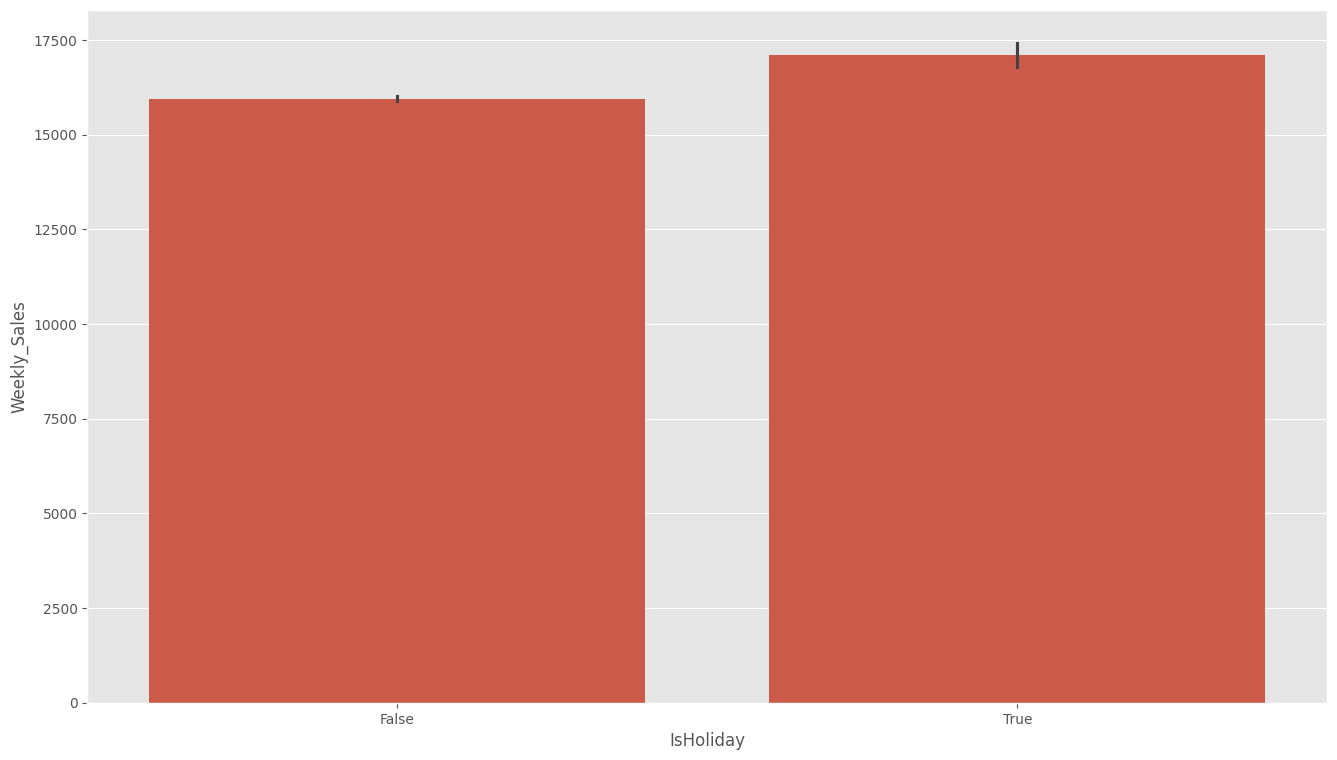

In [20]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

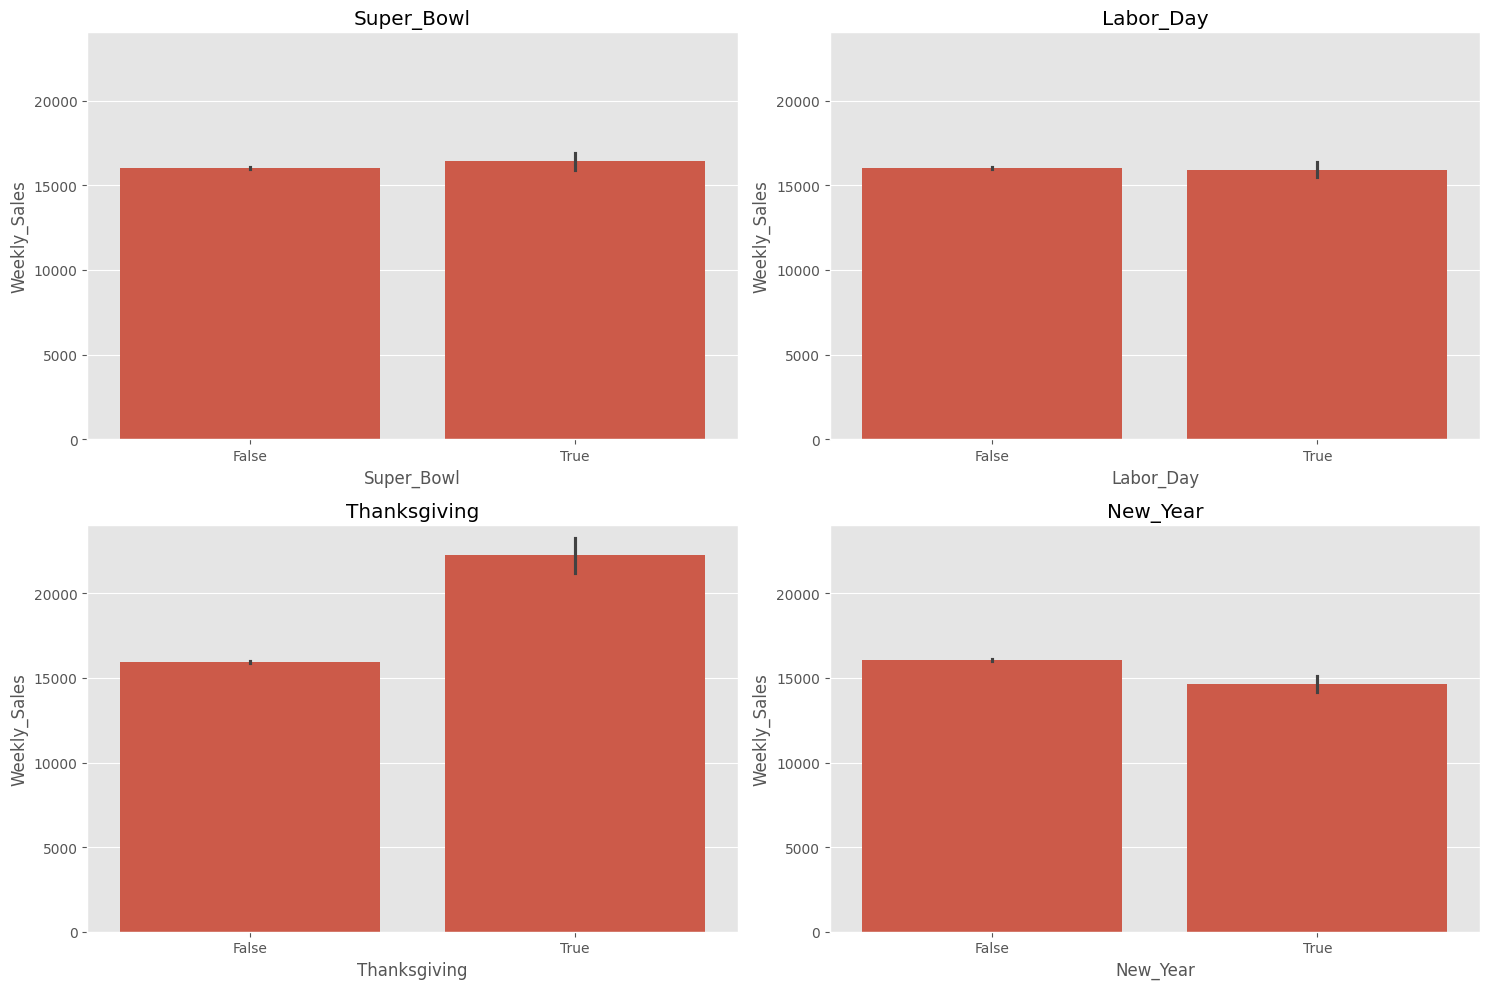

In [21]:
# Calcular el máximo valor de Weekly_Sales y definir el límite en 120% de ese valor
mean_ventas = df['Weekly_Sales'].mean()
limite_y = mean_ventas * 1.5

# Lista de holidays a visualizar y creación de subplots
holidays = ['Super_Bowl', 'Labor_Day', 'Thanksgiving', 'New_Year']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Iterar sobre cada holiday y generar el gráfico de barras correspondiente
for ax, holiday in zip(axes, holidays):
    sns.barplot(x=holiday, y='Weekly_Sales', data=df, ax=ax)
    ax.set_ylim(0, limite_y)
    ax.set_title(holiday)

plt.tight_layout()
plt.show()


Se puede evidenciar que los feriados como el año nuevo y el dia de accion de gracias tienen un impacto significativo en las ventas, mientras que los feriados como el dia del trabajo y el super bowl no tienen un impacto apreciable.

A continuación se evalua la cantidad de ventas para cada feriado, disciminando por tipo de tienda.

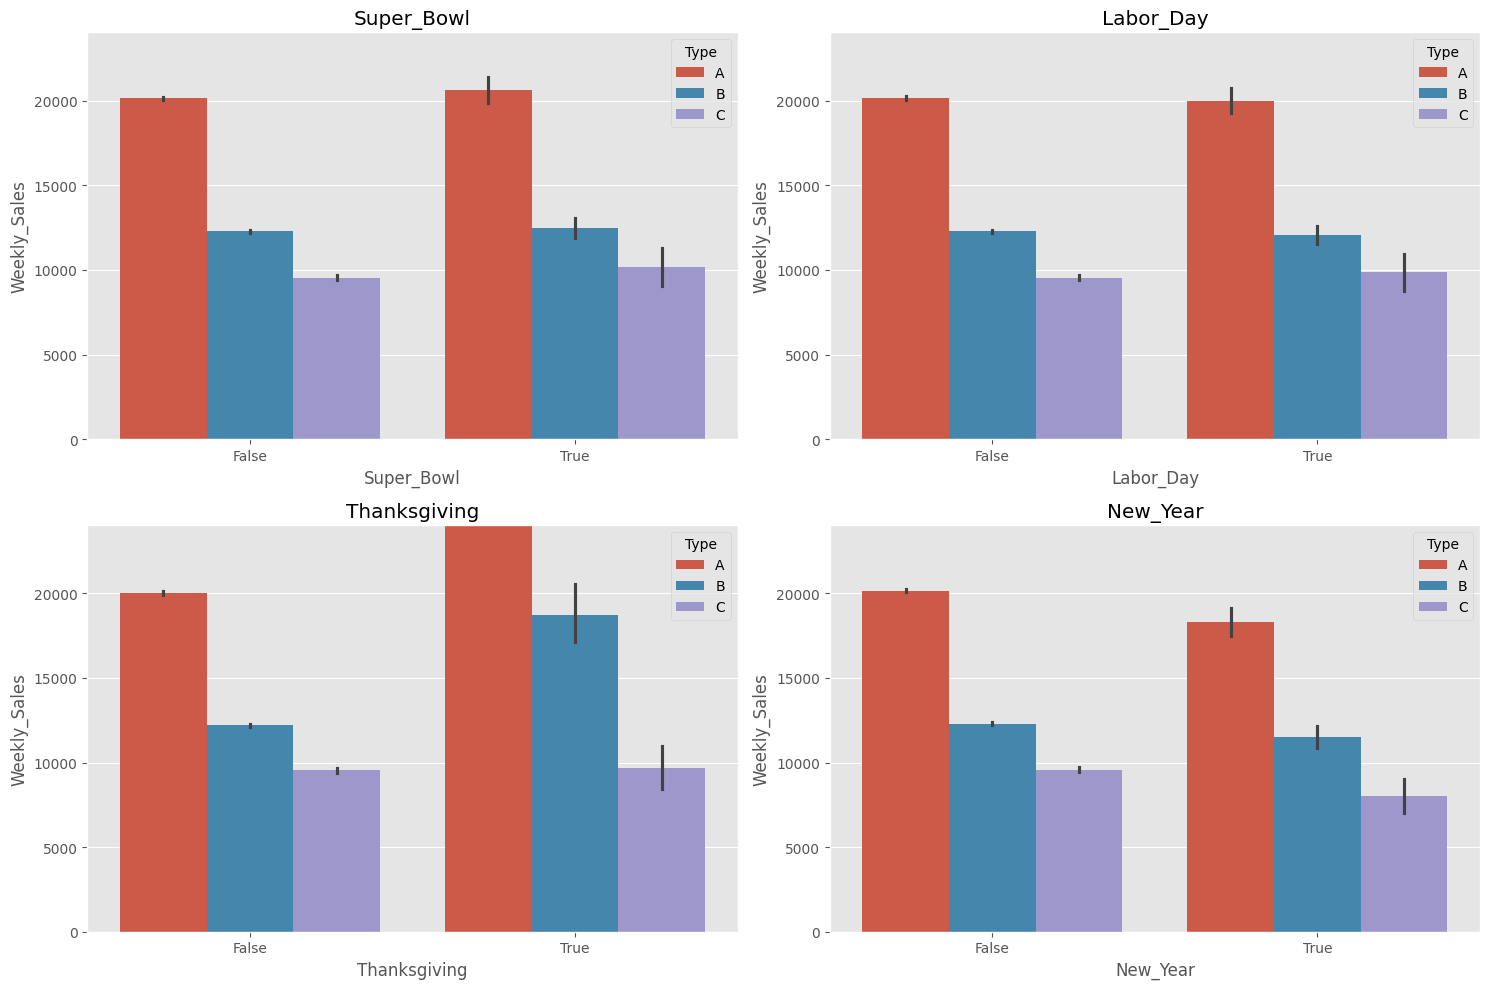

In [22]:
# A continuación se evalua la cantidad de ventas para cada feriado, disciminando por tipo de tienda.
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for ax, holiday in zip(axes, holidays):
    sns.barplot(x=holiday, y='Weekly_Sales', hue='Type', data=df, ax=ax)
    ax.set_ylim(0, limite_y)
    ax.set_title(holiday)

plt.tight_layout()
plt.show()

Se evidencia que la clasificacion de las tiendas está fuertemente relacionada con la cantidad de ventas que estas presentan, lo cual puede deberse a que el tipo indica el tamaño de las tiendas, y además, que los feriados tienen un impacto significativo en las ventas de cada una de las clasificaciones.

Además, se evidencia que los dias de accion de gracias son los que mayor impacto representan en las ventas de las tiendas, por lo que se procede a verificar cuantos de los registros con mayores ventas corresponden a dias de accion de gracias.

<Axes: xlabel='Type', ylabel='Size'>

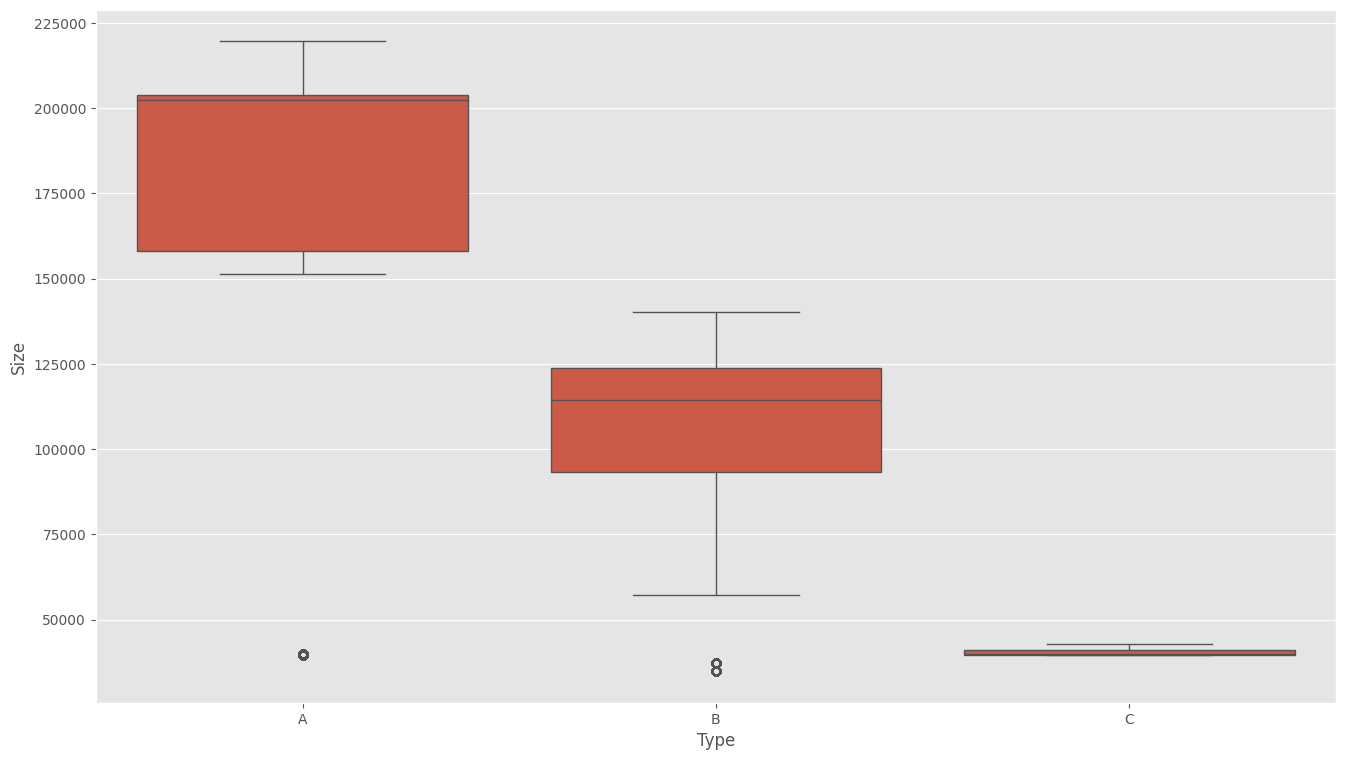

In [23]:
# Se revisa la relacion entre el tamaño de la tienda y el tipo con un boxplot
sns.boxplot(x='Type', y='Size', data=df)


In [24]:
# Se revisa la cantidad de las mayores ventas semanales que son un holiday
df.sort_values(by='Weekly_Sales', ascending=False).head(10).loc[:, ['Date', 'Weekly_Sales', 'Thanksgiving']]

,Date,Weekly_Sales,Thanksgiving
95373,2010-11-26,693099.36,True
338013,2011-11-25,649770.18,True
95425,2011-11-25,630999.19,True
337961,2010-11-26,627962.93,True
135665,2010-11-26,474330.10,True
195088,2010-11-26,422306.25,True
264390,2010-11-26,420586.57,True
88428,2010-12-24,406988.63,False
95377,2010-12-24,404245.03,False
214432,2010-11-26,393705.20,True


Se confirma entonces que el tipo de establecimiento indica el tamaño de la tienda, y que los dias de accion de gracias son los que mayor impacto tienen en las ventas.

### Filtrado de nulos
Para el correcto funcionamiento de los modelos de predicción, se deben eliminar los registros nulos. por lo que se procede a evaluar y tratar los nulos en el dataset.

In [25]:
# visualización de la cantidad de nulos por columna, imprimiendo tambien el tipo de columna y la cantidad de valores únicos
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum() / data.isnull().count() * 100)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

missing_data(df)

,Total,Percent
Store,0,0.00
Dept,0,0.00
Date,0,0.00
Weekly_Sales,0,0.00
IsHoliday,0,0.00
Temperature,0,0.00
Fuel_Price,0,0.00
MarkDown1,270085,64.26
MarkDown2,309367,73.61
MarkDown3,283618,67.48


In [26]:
# Exploremos ahora que contienen las variables con nulos

columns_with_nulls = df.columns[df.isnull().any()]
df[columns_with_nulls].describe()

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
count,150200.00,110918.00,136667.00,134535.00,150948.00
mean,7247.78,3329.92,1441.59,3384.72,4629.48
std,8292.90,9459.87,9631.42,6294.81,5959.85
min,0.27,-265.76,-29.10,0.22,135.16
25%,2240.27,41.60,5.10,504.22,1878.44
50%,5347.45,192.00,24.60,1481.31,3359.45
75%,9210.90,1926.94,103.99,3595.04,5563.80
max,88646.76,104519.54,141630.61,67474.85,108519.28


Notemos que son variables numéricas, por lo que se procede a teemplazar los nulos por 0

In [27]:
# Se reemplazan los valores nulos de la columna 'MarkDown' por 0
df.fillna(0, inplace=True)

Para finalizar con el análisis exxploratorio, se analiza la relación de las ventas con demás variables.

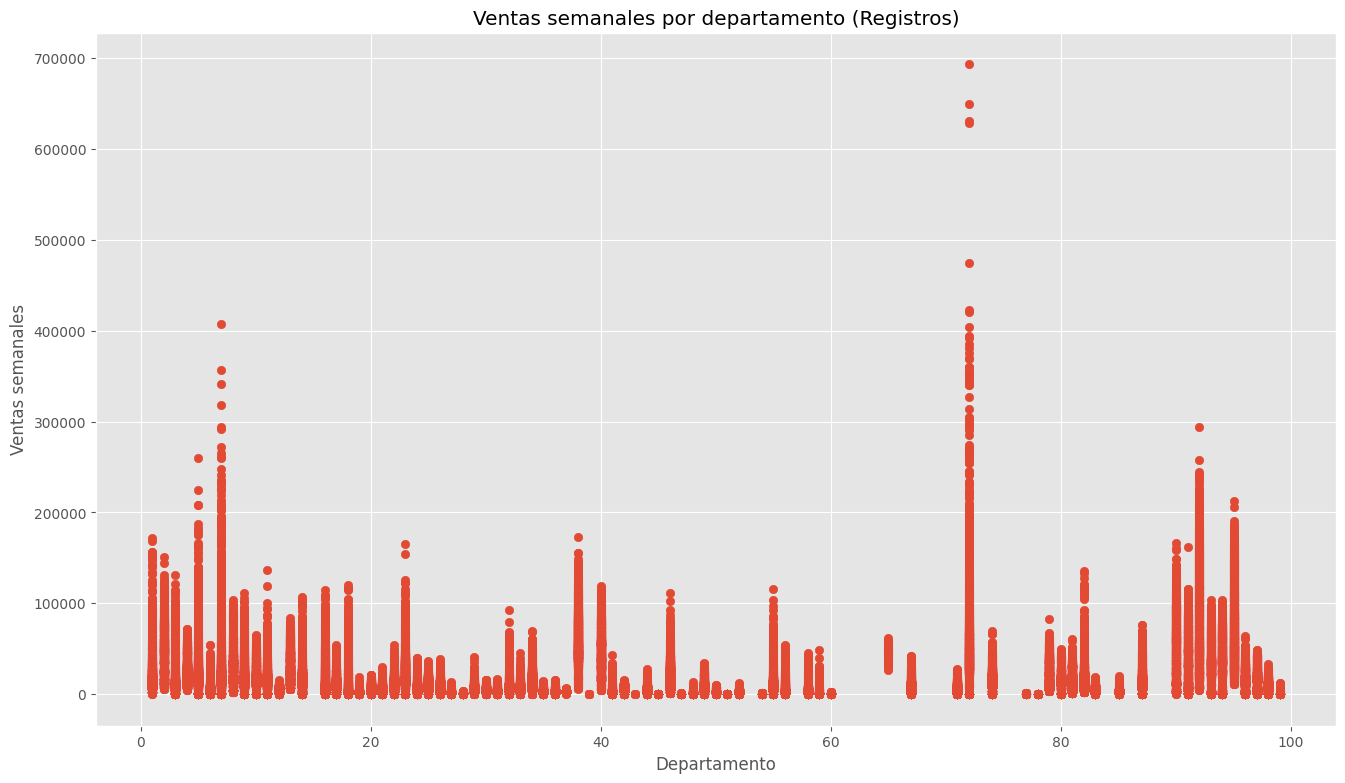

In [28]:
# Ventas por departamento en un scatter plot
plt.scatter(df['Dept'], df['Weekly_Sales'])
plt.xlabel('Departamento')
plt.ylabel('Ventas semanales')
plt.title('Ventas semanales por departamento (Registros)')


plt.show()


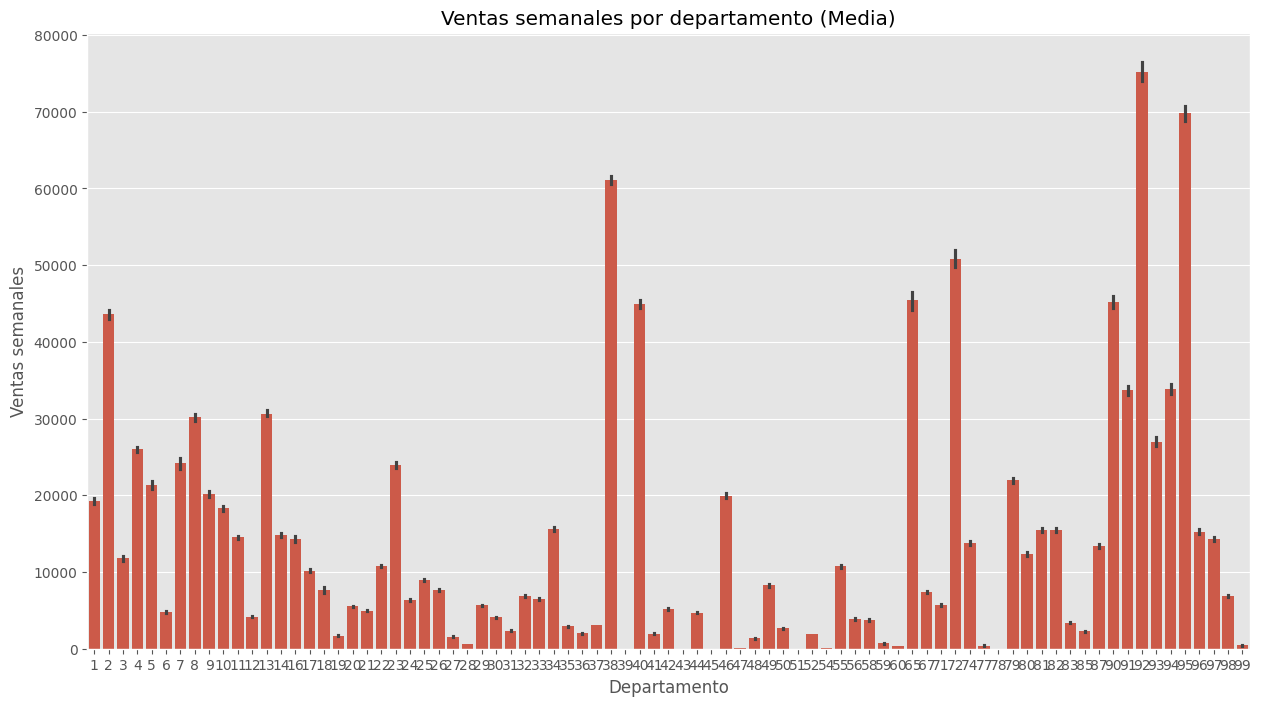

In [29]:
# Media de ventas semanales por departamento (barplot)
plt.figure(figsize=(15, 8))
sns.barplot(x='Dept', y='Weekly_Sales', data=df)
plt.xlabel('Departamento')
plt.ylabel('Ventas semanales')
plt.title('Ventas semanales por departamento (Media)')
plt.show()

Se evidencia que a pesar de que algunos departamentos son los que mayor total de ventas semanales presentan para algunos registros, no necesariamente son los que mayor cantidad de ventas presentan en promedio.

A continuación se realiza el mismo análisis para las tiendas.

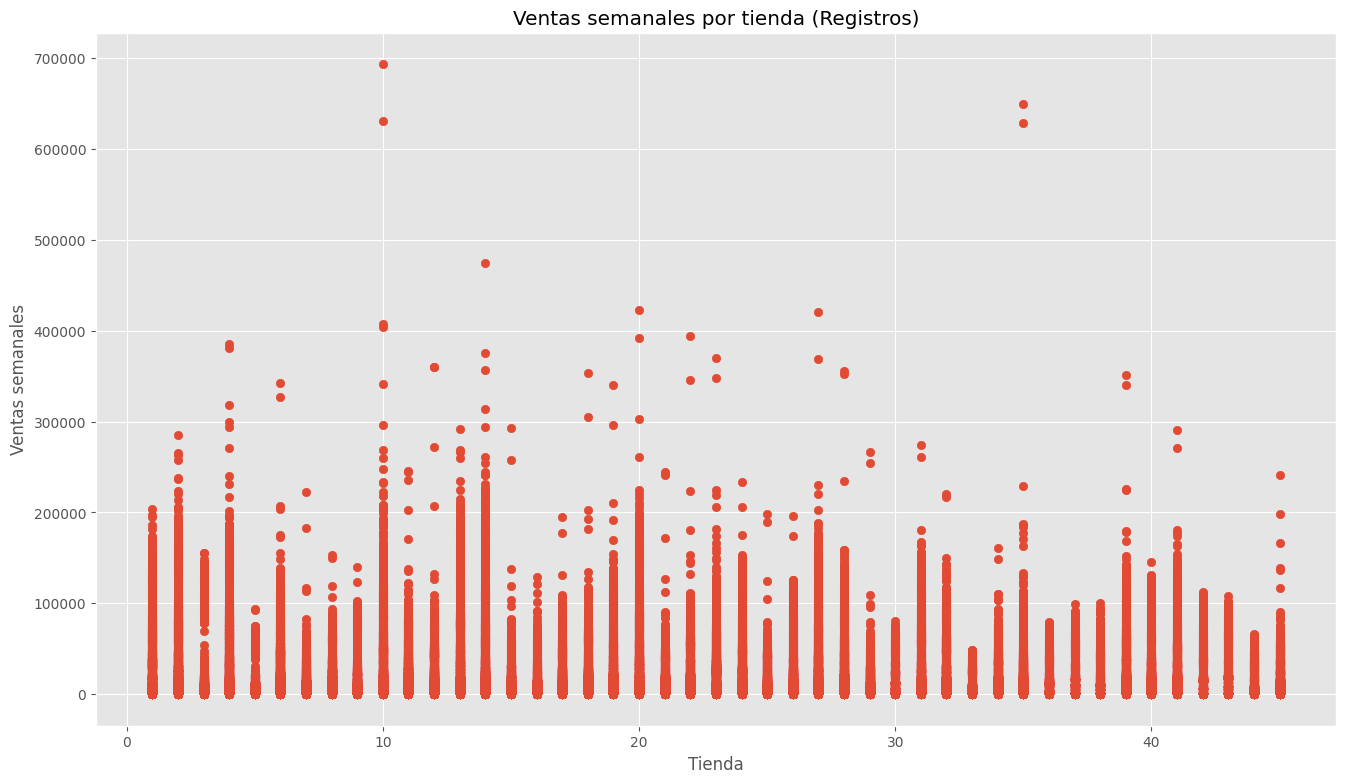

In [30]:
# Ventas por tienda en un scatter plot
plt.scatter(df['Store'], df['Weekly_Sales'])
plt.xlabel('Tienda')
plt.ylabel('Ventas semanales')
plt.title('Ventas semanales por tienda (Registros)')
plt.show()

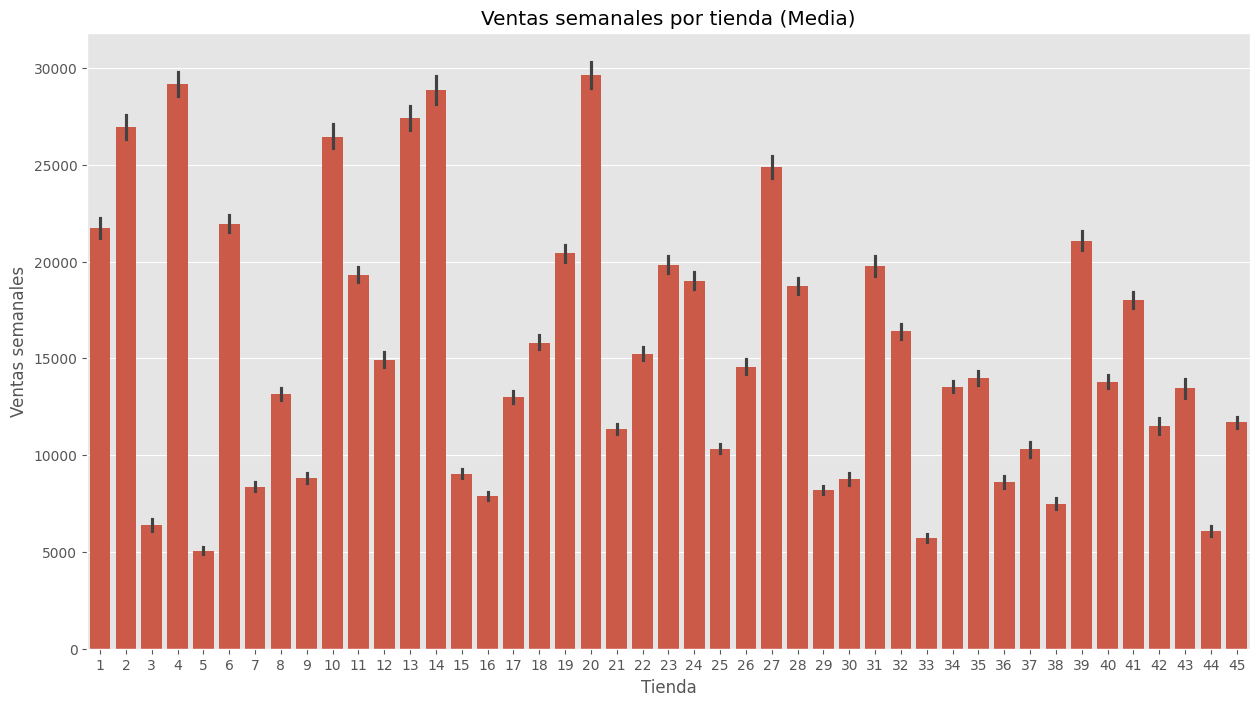

In [31]:
# Media de ventas semanales por tienda (barplot)
plt.figure(figsize=(15, 8))
sns.barplot(x='Store', y='Weekly_Sales', data=df)
plt.xlabel('Tienda')
plt.ylabel('Ventas semanales')
plt.title('Ventas semanales por tienda (Media)')
plt.show()

Se repite el comportamiento anterior, donde a pesar de que algunas tiendas presentan mayores ventas en algunos registros, no necesariamente son las que mayor cantidad de ventas presentan en promedio.

In [32]:
# Crear columnas para variables temporales
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week


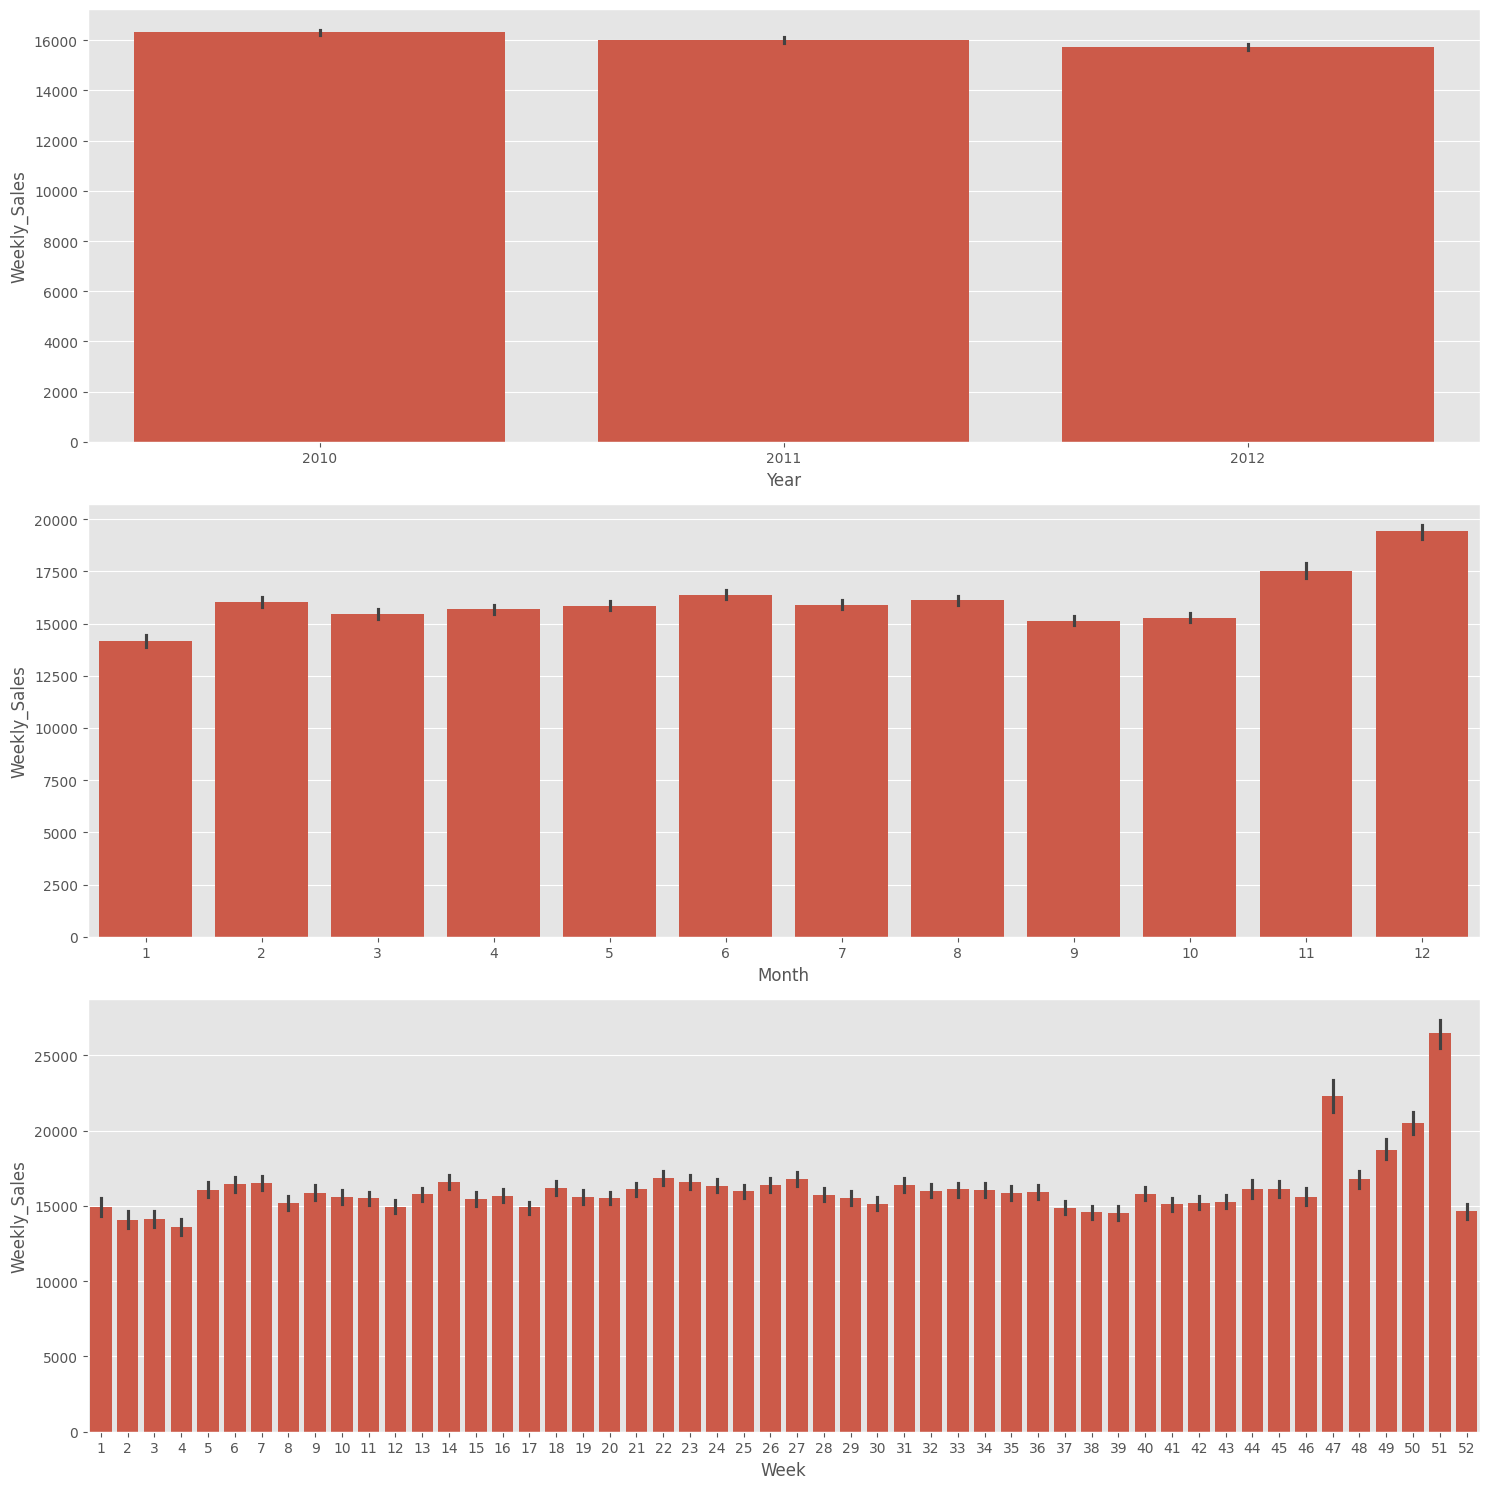

In [33]:
# Se realiza un diagrama de barras para analizar el mejor año, mes y semana en ventas
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
sns.barplot(x='Year', y='Weekly_Sales', data=df, ax=axes[0])
sns.barplot(x='Month', y='Weekly_Sales', data=df, ax=axes[1])
sns.barplot(x='Week', y='Weekly_Sales', data=df, ax=axes[2])

plt.tight_layout()
plt.show()

Como es de esperarse, los mejores meses en cuestion de ventas son los últimos del año, debido a las festividades de fin de año, lo cual se ve de igual manera representado en los rendimientos por semana, en la cual resalta la semana 47, en la cual se presenta el black friday.

In [34]:
# Finalmente, se almacenará el dataset limpio en un archivo CSV en la carpeta data/processed
!mkdir -p data/processed
df.to_csv('data/processed/cleaned_data.csv', index=False)

In [35]:
# Adicionalmente, se define un pipeline para preprocesar los datos de test
# de la misma forma que se hizo con los datos de entrenamiento
def preprocess_data(data):
    data = data.merge(df_features, on=['Store', 'Date', 'IsHoliday'], how='inner')
    data = data.merge(df_stores, on=['Store'], how='inner')
    data['Super_Bowl'] = data['Date'].isin(['2010-02-12', '2011-02-11', '2012-02-10'])
    data['Labor_Day'] = data['Date'].isin(['2010-09-10', '2011-09-09', '2012-09-07'])
    data['Thanksgiving'] = data['Date'].isin(['2010-11-26', '2011-11-25', '2012-11-23'])
    data['New_Year'] = data['Date'].isin(['2010-12-31', '2011-12-30', '2012-12-28'])
    data.fillna(0, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Week'] = data['Date'].dt.isocalendar().week

    return data


In [36]:
# procesar datos de prueba y guardarlos en un archivo CSV
df_test = pd.read_csv('data/raw/test.csv')
df_test = preprocess_data(df_test)
df_test.to_csv('data/processed/cleaned_test_data.csv', index=False)

#### Predicción de ventas semanales
Para abordar el caso de la predicción de las ventas semanales, se decide realizar un modelo que permita hacer la predicción discriminando por tienda y departamento. Ya que se tiene información detallada para cada uno de ellos, por lo que se puede hacer una estimación granular.

Con propósitos de experimentación, se define la carpeta en la que se almacenarán los resultados de estas pruebas, sin embargo este código será adaptado en la implementación web para, en lugar de guardar el gráfico, retornarlo para presentarlo al usario en una interfaz.

In [37]:
os.makedirs('forecast', exist_ok=True)

Inicialmente, se define una función que carga los datasets, y se hace la verificación de una columna esencial para las series de tiempo, que en este caso es la columna, Date.

In [38]:
def load_data():
    # Cargar datos de entrenamiento
    df_train = pd.read_csv('data/processed/cleaned_data.csv')
    df_train['Date'] = pd.to_datetime(df_train['Date'])
    df_train.sort_values('Date', inplace=True)

    # Cargar datos de test
    df_test = pd.read_csv('data/processed/cleaned_test_data.csv')
    df_test['Date'] = pd.to_datetime(df_test['Date'])
    df_test.sort_values('Date', inplace=True)

    return df_train, df_test

# Cargamos los datos para usarlos posteriormente
df_train, df_test = load_data()


Luego de ello, se define la función que transforma el conjunto de datos a la manera en que lo recibe el modelo de series de tiempo con el que se hará la predicción.

Éste modelo será un LSTM ya que es ideal para los datos secuenciales, y permite capturar patrones complejos y relaciones no lineales, en la evolución de los datos.

Éste modelo requiere una entrada de una serie de tiempo en una sencuencia de ventanas.

In [39]:
def create_dataset(data, window_size=4):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

Adicionalmente, se define la función que construye y entrena el modelo LSTM propuesto.

Se realiza un escalamiento de los datos, y luego se entrena el modelo. Finalmente, se retorna tanto el modelo como los datos predichos, y adicional, el scaler con el cual se procesaron los datos, ya que luego se deberá hacer la inversa de dichos datos.

In [40]:
def build_and_train_model(train_data, window_size=4, epochs=50, batch_size=32):
    # Escalar la variable 'Weekly_Sales'
    scaler = MinMaxScaler()
    sales = train_data['Weekly_Sales'].values.reshape(-1, 1)
    sales_scaled = scaler.fit_transform(sales)

    # Crear dataset para entrenar el modelo
    X, y_seq = create_dataset(sales_scaled, window_size)

    # Definir el modelo LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Entrenar el modelo
    model.fit(X, y_seq, epochs=epochs, batch_size=batch_size, verbose=0)

    return model, scaler, sales_scaled


Luego de tener todas las herramientas que permiten la construcción, y entrenamiento del modelo, se procede a realizar una función que predice de forma recursiva los siguientes periodos.

Esto debido a que se utilizará las predicciones del modelo para calcular las siguientes.

En este caso,  Se utiliza la última ventana conocida y se actualiza en cada iteración con la predicción obtenida.

In [41]:
def forecast_series(model, scaler, sales_scaled, window_size=4, n_forecast=30):
    current_sequence = sales_scaled[-window_size:].copy()
    forecast_scaled = []

    for _ in range(n_forecast):
        input_seq = current_sequence.reshape(1, window_size, 1)
        pred_scaled = model.predict(input_seq, verbose=0)
        forecast_scaled.append(pred_scaled[0, 0])

        # Actualizar la secuencia: eliminar el primer valor e incluir la predicción
        current_sequence = np.append(current_sequence[1:], [[pred_scaled[0, 0]]], axis=0)

    forecast_full = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))
    return forecast_full


Debido a que los requerimientos definen que se quiere predecir las fechas correspondientes al primer mes a partir de la primera fecha del test, se filtran de los resultados realizados

In [42]:
def get_forecast_dates(test_data):
    test_data = test_data.copy()
    test_data.sort_values('Date', inplace=True)
    all_forecast_dates = test_data['Date'].reset_index(drop=True)
    first_forecast_date = all_forecast_dates.iloc[0]
    mask_first_month = (all_forecast_dates.dt.month == first_forecast_date.month) & \
                       (all_forecast_dates.dt.year == first_forecast_date.year)
    forecast_dates_first_month = all_forecast_dates[mask_first_month].reset_index(drop=True)
    return forecast_dates_first_month


Adicionalmente, para una mejor visualización para el usuario, se filtran los últimos 120 días (3 meses), con valores conocidos, para agregarlos a la grafica de predicción, y así brindarle un panorama completo.

In [43]:
def get_actual_last(train_data, days=120):
    last_train_date = train_data['Date'].max()
    start_date = last_train_date - pd.Timedelta(days=days)
    actual_last = train_data[train_data['Date'] >= start_date][['Date', 'Weekly_Sales']].copy()
    actual_last.rename(columns={'Weekly_Sales': 'Sales'}, inplace=True)
    return actual_last


Se define también una función que grafica la serie de ventas reales (últimos 120 días) y las predicciones del primer mes. Además, se traza una línea que conecta el último dato real con la primera predicción utilizando el mismo estilo que la línea de forecast, para dar continuidad visual.

In [44]:
def plot_forecast(actual_last, forecast_df, store, dept, forecast_color='tab:blue'):
    plt.figure(figsize=(12,6))
    plt.plot(actual_last['Date'], actual_last['Sales'], label='Ventas Reales (Últimos 120 días)', marker='o')
    plt.plot(forecast_df['Date'], forecast_df['Sales'], label='Pronóstico (Primer Mes Predicho)',
             marker='x', linestyle='--', color=forecast_color)

    # Conectar el último registro real con la primera predicción con el mismo estilo del forecast
    if (not actual_last.empty) and (not forecast_df.empty):
        plt.plot([actual_last['Date'].iloc[-1], forecast_df['Date'].iloc[0]],
                 [actual_last['Sales'].iloc[-1], forecast_df['Sales'].iloc[0]],
                 linestyle='--', color=forecast_color)

    plt.title(f'Store {store} Dept {dept} - Forecast')
    plt.xlabel('Fecha')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Guardar el gráfico (Que en el desarrollo web se reemplazaría por mostrar al usuario)
    plot_filename = f"forecast/store_{store}_dept_{dept}.png"
    plt.savefig(plot_filename)
    plt.close()
    return plot_filename


Finalmente se define una función que integra todos los pasos anteriores, para que dado un número de tienda y departamento, se filtran los datos correspondientes, se entrena el modelo, se genera la predicción recursiva, se obtienen las fechas del forecast, se extraen los datos reales y se genera el gráfico. Finalmente, se guarda el gráfico y el CSV con la información combinada.

In [45]:
def process_forecast(store, dept, df_train, df_test, window_size=4, n_forecast=30):
    # Filtrar datos de train para la tienda y dept especificados
    train_data = df_train[(df_train['Store'] == store) & (df_train['Dept'] == dept)].copy()
    train_data.sort_values('Date', inplace=True)

    # Verificar que haya suficientes datos para entrenar
    if len(train_data) < window_size + 1:
        print(f"Datos insuficientes para Store {store} Dept {dept}.")
        return None, None

    # Entrenar el modelo
    model, scaler, sales_scaled = build_and_train_model(train_data, window_size=window_size)

    # Realizar la predicción recursiva de n_forecast períodos
    forecast_full = forecast_series(model, scaler, sales_scaled, window_size=window_size, n_forecast=n_forecast)

    # Filtrar datos de test para la tienda y dept especificados
    test_data = df_test[(df_test['Store'] == store) & (df_test['Dept'] == dept)].copy()
    test_data.sort_values('Date', inplace=True)
    if test_data.empty:
        print(f"No hay datos de test para Store {store} Dept {dept}.")
        return None, None

    # Obtener las fechas del primer mes predicho a partir del test
    forecast_dates_first_month = get_forecast_dates(test_data)
    n_first_month = len(forecast_dates_first_month)

    # Usar solo las predicciones correspondientes al primer mes
    forecast_first_month = forecast_full[:n_first_month]

    # Crear el dataframe de forecast
    forecast_df = pd.DataFrame({
        'Date': forecast_dates_first_month,
        'Sales': forecast_first_month.flatten()
    })

    # Obtener los últimos 120 días reales del train
    actual_last = get_actual_last(train_data, days=120)

    # Combinar la serie real y el forecast (para guardar el CSV)
    combined_df = pd.concat([actual_last, forecast_df], ignore_index=True)

    # Graficar la serie y guardar el gráfico
    plot_filename = plot_forecast(actual_last, forecast_df, store, dept, forecast_color='tab:blue')

    # Guardar el dataframe combinado
    csv_filename = f"forecast/store_{store}_dept_{dept}.csv"
    combined_df.to_csv(csv_filename, index=False)

    print(f"Guardado gráfico en: {plot_filename}")
    print(f"Guardado dataframe en: {csv_filename}")

    return combined_df, plot_filename


Adicionalmente se añade en la siguiente celda de código un ejemplo de llamado a la función, la cual permite experimentar con el modelo.

In [46]:
# Ejemplo: Procesar forecast para Store 1 y Dept 1
combined_df, plot_file = process_forecast(1, 1, df_train, df_test)


Guardado gráfico en: forecast/store_1_dept_1.png
Guardado dataframe en: forecast/store_1_dept_1.csv
